## Load libraries

In [12]:
import pandas as pd
import numpy as np
import helper as h

import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance
from numpy import sort
from sklearn.feature_selection import SelectFromModel

import eli5

import scipy.stats
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Upload data

In [3]:
df_train = pd.read_hdf("../input/train_data.h5")
df_train['price'] = df_train['price'].map(h.parse_price)

df_test = pd.read_hdf("../input/test_data.h5")

## Combine data
Combine `df_train` and` df_test` and save the result to `df`.

In [4]:
df = pd.concat([df_train, df_test])
print(df.shape, df.shape)

(34180, 8) (34180, 8)


In [5]:
df.sample(5)

,geo_block,breadcrumbs,price,owner,params,date,user_block,id
13874,"[г. Москва, Кунцево, г. Москва, Кунцево]","[Москва, Кунцево, м. Молодежная, МЦК Стрешнево]",6.54812,[],"{'Лифт:': 'да', 'Охрана:': 'предусмотрена', 'Т...","[2 апреля, 5, (+1 за сегодня), Обновлено 14 мая]","[<div class=""block-user__name"">Группа ПИК</div...",22107
17462,"[г. Зеленоград, г. Зеленоград]","[Москва, г. Зеленоград, МЦК Балтийская]",8.50000,[],"{'Общая площадь:': '75 м²', 'Дата публикации:'...","[2 апреля, 12, (+1 за сегодня), Обновлено 18 мая]","[<div class=""block-user__name"">Вероника</div>,...",36055
18231,"[г. Москва, Орехово-Борисово Южное, г. Москва,...","[Москва, Орехово-Борисово Южное, м. Домодедовс...",11.20560,[],"{'Лифт:': 'да', 'Тип здания:': 'Монолитное', '...","[2 марта, 16, (+1 за сегодня), Обновлено 13 мая]","[<div class=""block-user__name"">MR-Group</div>,...",29878
12685,"[г. Москва, Даниловский, г. Москва, Даниловский]","[Москва, Даниловский, м. Автозаводская, МЦК ЗИЛ]",12.76309,[],"{'Охрана:': 'предусмотрена', 'Тип здания:': 'М...","[15 мая, 2, (+1 за сегодня)]","[<div class=""block-user__name"">Регион</div>, <...",60249
4060,"[г. Москва, Орехово-Борисово Южное, г. Москва,...","[Москва, Орехово-Борисово Южное, м. Домодедовс...",NaN,[],"{'Лифт:': 'да', 'Тип здания:': 'Монолитное', '...","[9 апреля, 8, (+1 за сегодня), Обновлено 13 мая]","[<div class=""block-user__name"">Группа ПИК</div...",29580


## Initial data analysis and preparation

In [6]:
print ('Number of observations:',df.shape[0],'\n')
print('Types of features :\n',df.dtypes,'\n')
print ('Number of features:',df.shape[1],'\n')
print ('Lack of data:',df.isnull().any().any(),'\n')


Number of observations: 34180 

Types of features :
 geo_block       object
breadcrumbs     object
price          float64
owner           object
params          object
date            object
user_block      object
id               int64
dtype: object 

Number of features: 8 

Lack of data: True 



In [7]:
df[['price']].describe()

,price
count,22732.000000
mean,17.525508
std,44.079082
min,1.040000
25%,7.162347
50%,9.888750
75%,15.410000
max,3000.000015


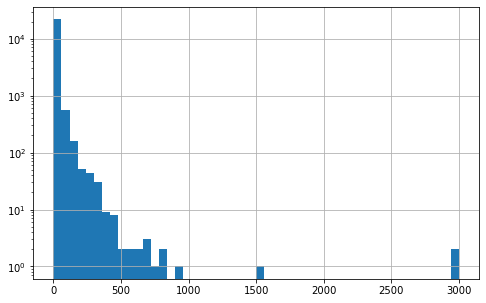

In [8]:
df.price.hist(figsize=(8,5), bins=50, log=True);

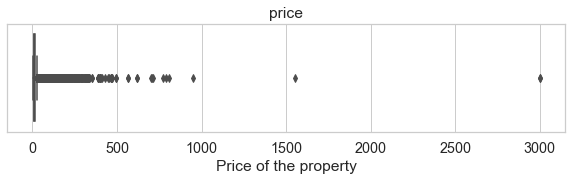

Feature is normally distributed


In [13]:
plt.figure(figsize=(10,2))
sns.set(font_scale=1.3, style="whitegrid")
sns.boxplot(df['price'],palette = ['gray']).set(title = 'price', xlabel = 'Price of the property')
plt.show()

if(scipy.stats.normaltest(df['price'])[1] < 0.05): #Normal distribution test 
    print('Feature is not normally distributed')
else:
    print('Feature is normally distributed')

In [14]:
#general comparison
df.select_dtypes(include = ['object']).describe()

,geo_block,breadcrumbs,owner,params,date,user_block
count,34180,34180,34180,34180,34180,34180
unique,983,1497,211,33094,11193,1365
top,"[г. Москва, г. Москва]","[Москва, Новая Москва, п. Сосенское, п. Коммун...",[],"{'Лифт:': 'да', 'Охрана:': 'предусмотрена', 'Т...","[16 мая, 2, (+1 за сегодня)]",[]
freq,9225,1140,30647,7,560,3543


In [15]:
print(df['geo_block'].value_counts(normalize = True))

[г. Москва, г. Москва]                                                                                                                    0.269895
[Новая Москва, п. Сосенское, п. Коммунарка, Южное Бутово, Новая Москва, п. Сосенское, п. Коммунарка, Южное Бутово]                        0.033353
[г. Москва, Хорошёво-Мнёвники, г. Москва, Хорошёво-Мнёвники]                                                                              0.030925
[г. Москва, Филёвский Парк, г. Москва, Филёвский Парк]                                                                                    0.027384
[г. Москва, Некрасовка, г. Москва, Некрасовка]                                                                                            0.017642
                                                                                                                                            ...   
[г. Москва, Выхино-Жулебино, проезд Ферганский, г. Москва, Выхино-Жулебино, проезд Ферганский]                        

In [16]:
print(df['breadcrumbs'].value_counts(normalize = True))

[Москва, Новая Москва, п. Сосенское, п. Коммунарка, Южное Бутово, м. Бунинская Аллея, МЦК Крымская]    0.033353
[Москва, МЦК Лужники]                                                                                  0.031393
[Москва, МЦК Кутузовская]                                                                              0.023347
[Москва, МЦК Крымская]                                                                                 0.020509
[Москва, МЦК Шелепиха]                                                                                 0.018812
                                                                                                         ...   
[Москва, МЦК Соколиная Гора, ул. Буракова]                                                             0.000029
[Москва, Новая Москва, п. Рязановское, д. Ерино, Чертаново Южное, м. Аннино, МЦК Крымская]             0.000029
[Москва, Северный, м. ЦСКА, МЦК Зорге]                                                                 0

In [17]:
print(df['owner'].value_counts(normalize = True))

[]                                 0.896635
[ЖК "Крылья". Доп. скидка 5%!]     0.010415
[Квартиры в ЖК "Аквилон PARK"!]    0.007226
[Переделкино Ближнее]              0.006173
[Район «Скандинавия»]              0.005851
                                     ...   
[Светлана Светлана]                0.000029
[Алексей]                          0.000029
[МОСКОВСКИЙ РИЭЛТОР]               0.000029
[Двойных Любовь Георгиевна]        0.000029
[Андрей Спиркин]                   0.000029
Name: owner, Length: 211, dtype: float64


In [18]:
print(df['params'].value_counts(normalize = True))

{'Лифт:': 'да', 'Охрана:': 'предусмотрена', 'Тип здания:': 'Монолитное', 'Тип объекта:': 'квартира', 'Количество корпусов:': '8', 'Тип объявления:': 'от застройщика', 'Застройщик:': 'Группа ЛСР (LSR)', 'Общая площадь:': '87.27 м²', 'Дата публикации:': '22 апреля', 'Тип санузла:': 'раздельный', 'Площадь кухни:': '20.8 м²', 'Количество комнат:': '3', 'Парковка:': 'подземная', 'Дата  обновления:': 'сегодня в 05:54', 'Класс жилья:': 'Комфорт класс', 'Год постройки:': '2021', 'Количество этажей:': '19', 'Комиссия агенту:': 'без комиссии', 'Высота потолков:': '2.72 м', 'Этаж:': '2/19', 'Жилая комната:': '47.53 м²', 'Мусоропровод:': 'да', 'Этап строительства:': 'Отделка', 'Новостройка:': 'ЖК «Лучи», м. Румянцево', 'Возможна ипотека:': 'да', 'Адрес:': ''}                                                                        0.000205
{'Охрана:': 'предусмотрена', 'Тип здания:': 'Монолитное', 'Тип объекта:': 'квартира', 'Количество корпусов:': '12', 'Тип объявления:': 'от застройщика', 'Застройщ

In [19]:
print(df['date'].value_counts(normalize = True))

[16 мая, 2, (+1 за сегодня)]                                 0.016384
[16 мая, 3, (+1 за сегодня)]                                 0.009830
[17 мая, 3, (+2 за сегодня)]                                 0.009684
[17 мая, 2, (+1 за сегодня)]                                 0.009450
[18 мая, 3, (+2 за сегодня)]                                 0.008104
                                                               ...   
[26 апреля, 48, (+1 за сегодня)]                             0.000029
[9 февраля, 11, (+1 за сегодня), Обновлено вчера в 10:47]    0.000029
[7 февраля, 28, (+2 за сегодня), Обновлено 18 мая]           0.000029
[1 июня 2015, 480, (+1 за сегодня), Обновлено 17 мая]        0.000029
[5 февраля, 5, (+2 за сегодня), Обновлено 17 мая]            0.000029
Name: date, Length: 11193, dtype: float64


In [20]:
print(df['user_block'].value_counts(normalize = True))

[]                                                                                                              0.103657
[<div class="block-user__name">Группа ПИК</div>, <div class="block-user__agency">Группа ПИК</div>]              0.097425
[<div class="block-user__name">Агент</div>, <div class="block-user__agency">Риелтор</div>]                      0.086747
[<div class="block-user__name">MR-Group</div>, <div class="block-user__agency">MR-Group</div>]                  0.045963
[<div class="block-user__name">Агент</div>, <div class="block-user__agency">Застройщик</div>]                   0.039087
                                                                                                                  ...   
[<div class="block-user__name">Халида Борисенко</div>, <div class="block-user__agency"></div>]                  0.000029
[<div class="block-user__name">МИЭЛЬ-Сеть офисов недвижимости</div>, <div class="block-user__agency"></div>]    0.000029
[<div class="block-user__name">М

### Categorization of the Params feature

In [5]:
params = df["params"].apply(pd.Series)
params = params.fillna(-1)

if "Охрана:" not in df:  #prevents params from being added again 
    df = pd.concat([df, params], axis=1)
    
    obj_feats = params.select_dtypes(object).columns

    for feat in obj_feats:
        df["{}_cat".format(feat)] = df[feat].factorize()[0]

cat_feats = [x for x in df.columns if "_cat" in x]
cat_feats

['Охрана:_cat',
 'Тип здания:_cat',
 'Тип объекта:_cat',
 'Количество корпусов:_cat',
 'Тип объявления:_cat',
 'Застройщик:_cat',
 'Общая площадь:_cat',
 'Дата публикации:_cat',
 'Количество комнат:_cat',
 'Парковка:_cat',
 'Дата  обновления:_cat',
 'Количество этажей:_cat',
 'Сдача:_cat',
 'Комиссия агенту:_cat',
 'Высота потолков:_cat',
 'Этаж:_cat',
 'Этап строительства:_cat',
 'Новостройка:_cat',
 'Количество квартир:_cat',
 'Класс жилья:_cat',
 'Адрес:_cat',
 'Лифт:_cat',
 'Вид из окна:_cat',
 'Возможна ипотека:_cat',
 'Год постройки:_cat',
 'Этажность:_cat',
 'Мусоропровод:_cat',
 'Ремонт:_cat',
 'Площадь кухни:_cat',
 'Жилая комната:_cat',
 'Тип санузла:_cat',
 'Тип балкона:_cat',
 'Мебель на кухне:_cat',
 'Холодильник:_cat',
 'Интернет:_cat',
 'Мебель:_cat',
 'Телефон:_cat',
 'Свободная планировка:_cat',
 'Управляющая компания:_cat',
 'Количество подъездов:_cat',
 'Тип дома:_cat',
 'Тип комнат:_cat',
 'Покрытие пола:_cat',
 'Серия:_cat',
 'Тип перекрытия:_cat',
 'Возможен торг:

### Features of area 

In [6]:
def parse_area(val):
    if isinstance(val, int): return val
    if isinstance(val, float): return val
    
    return float(val.split("м")[0].replace(" ", ""))

df["area"] = df["Общая площадь:"].map(h.parse_area)
df["kitchen_area"] = df["Площадь кухни:"].map(parse_area)

### model evaluation 

Two functions: `check_model`, `check_log_model`. 

In [7]:
def check_model(df, feats, model, cv=5, scoring="neg_mean_absolute_error"):
    df_train = df[ ~df["price"].isnull() ].copy()
    df_test = df[ df["price"].isnull() ].copy()

    X_train = df_train[feats]
    y_train = df_train["price"]
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
    return np.mean(scores), np.std(scores)


def check_log_model(df, feats, model, cv=5, scoring="neg_mean_absolute_error"):
    df_train = df[ ~df["price"].isnull() ].copy()

    X = df_train[feats]
    y = df_train["price"]
    y_log = np.log(y)
    
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]

        model = xgb.XGBRegressor(max_depth=5, n_estimators=50, random_state=0)
        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)

        score = mean_absolute_error(y_test, y_pred)
        scores.append(score)

    return np.mean(scores), np.std(scores)

## Features of area 
Selected features: `geo_block` i `breadcrumbs`.

### geo_block

In [8]:
df["geo_block"].values

array([list(['г. Москва', 'Лианозово', 'г. Москва', 'Лианозово']),
       list(['г. Москва', 'Ховрино', 'г. Москва', 'Ховрино']),
       list(['г. Москва', 'ул Лобачевского', 'г. Москва', 'ул Лобачевского']),
       ..., list(['г. Москва', 'Ховрино', 'г. Москва', 'Ховрино']),
       list(['Новая Москва', 'п. Внуковское', 'г. Москва', 'Новая Москва', 'п. Внуковское', 'г. Москва']),
       list(['г. Москва', 'Ярославский', 'ул Красная Сосна', 'г. Москва', 'Ярославский', 'ул Красная Сосна'])],
      dtype=object)

Removal of duplicates, because in the lines we have two elements repeated twice. 

In [9]:
df["geo_block_norm"] = df["geo_block"].map(lambda x: x[:int(len(x)/2)])

df["geo_block_norm"]

0                            [г. Москва, Лианозово]
1                              [г. Москва, Ховрино]
2                      [г. Москва, ул Лобачевского]
3                  [г. Москва, Ховрино, ул Дыбенко]
4                          [г. Москва, Даниловский]
                            ...                    
11443                                   [г. Москва]
11444                [г. Москва, Хорошёво-Мнёвники]
11445                          [г. Москва, Ховрино]
11446      [Новая Москва, п. Внуковское, г. Москва]
11447    [г. Москва, Ярославский, ул Красная Сосна]
Name: geo_block_norm, Length: 34180, dtype: object

Create `DataFrame`.

In [10]:
geo_block = (
df["geo_block"]
    .map(lambda x: x[:int(len(x)/2) ])
    .map(lambda x: {"geo_block_{}".format(idx):val for idx,val in enumerate(x) })
    .apply(pd.Series)
)

geo_block

,geo_block_0,geo_block_1,geo_block_2,geo_block_3,geo_block_4,geo_block_5
0,г. Москва,Лианозово,NaN,NaN,NaN,NaN
1,г. Москва,Ховрино,NaN,NaN,NaN,NaN
2,г. Москва,ул Лобачевского,NaN,NaN,NaN,NaN
3,г. Москва,Ховрино,ул Дыбенко,NaN,NaN,NaN
4,г. Москва,Даниловский,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
11443,г. Москва,NaN,NaN,NaN,NaN,NaN
11444,г. Москва,Хорошёво-Мнёвники,NaN,NaN,NaN,NaN
11445,г. Москва,Ховрино,NaN,NaN,NaN,NaN
11446,Новая Москва,п. Внуковское,г. Москва,NaN,NaN,NaN


Categorization of the `geo_block` feature

In [11]:

for feat in geo_block.columns:
    print(feat)
    print(geo_block[feat].value_counts().head(20))
    print("="*100)
    print()
    

    df["{}_cat".format(feat)] = geo_block[feat].factorize()[0]

geo_block_0
г. Москва             29049
Новая Москва           4531
г. Зеленоград           318
п. Свиблово             138
п. Некрасовка           134
п. Новобратцевский        3
пгт Акулово               1
п. Крюково                1
д. Сколково               1
п. Рублево                1
п. Алабушево              1
п. Главмосстроя           1
п. Подушкино              1
Name: geo_block_0, dtype: int64

geo_block_1
п. Сосенское              2522
Хорошёво-Мнёвники         1142
Филёвский Парк             945
п. Московский              919
Ховрино                    829
Раменки                    811
Люблино                    666
Некрасовка                 654
Кунцево                    537
Орехово-Борисово Южное     534
ул Дыбенко                 525
Выхино-Жулебино            496
Зябликово                  492
ул Лобачевского            442
п. Внуковское              430
Рязанский                  425
Марьино                    407
Пресненский                378
Лефортово            

In [12]:
geo_cat_feats = [x for x in df.columns if "geo_block" in x and "_cat" in x]
geo_cat_feats

['geo_block_0_cat',
 'geo_block_1_cat',
 'geo_block_2_cat',
 'geo_block_3_cat',
 'geo_block_4_cat',
 'geo_block_5_cat']

### Check result

In [13]:
feats = ["area", "kitchen_area"] + geo_cat_feats + cat_feats

check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(3.25358809911422, 0.3150982251982633)

### Breadcrumbs 


In [14]:
breadcrumbs = (
    df["breadcrumbs"]
        .map(lambda x: {"breadcrumbs_{}".format(idx):val for idx,val in enumerate(x) })
        .apply(pd.Series)
)

breadcrumbs

,breadcrumbs_0,breadcrumbs_1,breadcrumbs_2,breadcrumbs_3,breadcrumbs_4,breadcrumbs_5,breadcrumbs_6,breadcrumbs_7
0,Москва,Лианозово,м. Алтуфьево,МЦК Лихоборы,NaN,NaN,NaN,NaN
1,Москва,Ховрино,м. Ховрино,МЦК Коптево,NaN,NaN,NaN,NaN
2,Москва,МЦК Кутузовская,ул. Лобачевского,NaN,NaN,NaN,NaN,NaN
3,Москва,Ховрино,м. Ховрино,МЦК Коптево,ул. Дыбенко,NaN,NaN,NaN
4,Москва,Даниловский,м. Автозаводская,МЦК Автозаводская,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
11443,Москва,МЦК Кутузовская,NaN,NaN,NaN,NaN,NaN,NaN
11444,Москва,Хорошёво-Мнёвники,м. Октябрьское поле,МЦК Зорге,NaN,NaN,NaN,NaN
11445,Москва,Ховрино,м. Ховрино,МЦК Коптево,NaN,NaN,NaN,NaN
11446,Москва,Новая Москва,п. Внуковское,МЦК Кутузовская,NaN,NaN,NaN,NaN


Categorization of the `breadcrumbs` feature

In [15]:
for feat in breadcrumbs.columns:
    print(feat)
    print(breadcrumbs[feat].value_counts().head(20))
    print("="*100)
    print()
    

    df["{}_cat".format(feat)] = breadcrumbs[feat].factorize()[0]

breadcrumbs_0
Москва    34180
Name: breadcrumbs_0, dtype: int64

breadcrumbs_1
Новая Москва              4531
МЦК Лужники               1245
МЦК Кутузовская           1237
Хорошёво-Мнёвники         1142
Филёвский Парк             945
МЦК Крымская               932
МЦК Шелепиха               842
Ховрино                    829
Раменки                    811
МЦК Коптево                800
Люблино                    666
МЦК Хорошёво               633
Некрасовка                 608
МЦК Нижегородская          564
МЦК Лихоборы               549
Кунцево                    537
Орехово-Борисово Южное     534
Выхино-Жулебино            494
Зябликово                  492
МЦК Ростокино              453
Name: breadcrumbs_1, dtype: int64

breadcrumbs_2
п. Сосенское             2522
п. Московский             919
м. Октябрьское поле       864
м. Выхино                 856
м. Ховрино                829
м. Братиславская          649
м. Рязанский проспект     600
м. Пятницкое шоссе        558
м. Фили     

In [16]:
breadcrumbs_cat_feats = [x for x in df.columns if "breadcrumbs" in x and "_cat" in x]
breadcrumbs_cat_feats

['breadcrumbs_0_cat',
 'breadcrumbs_1_cat',
 'breadcrumbs_2_cat',
 'breadcrumbs_3_cat',
 'breadcrumbs_4_cat',
 'breadcrumbs_5_cat',
 'breadcrumbs_6_cat',
 'breadcrumbs_7_cat']

A selection of the 7 best features from `breadcrumbs`. 

In [17]:
beast_feats = ['Общая площадь:_cat',
 'Класс жилья:_cat',
 'Этаж:_cat',
 'Количество комнат:_cat',
 'Высота потолков:_cat',
 'Дата публикации:_cat',
 'Тип балкона:_cat',
 'Застройщик:_cat',
 'Парковка:_cat',
 'Количество квартир:_cat',
 'Количество этажей:_cat',
 'Площадь кухни:_cat',
 'Жилая комната:_cat',
 'Охрана:_cat',
 'Тип здания:_cat',
 'Год постройки:_cat',
 'Сдача:_cat'
              ]

### Check result

In [18]:
feats = ["area", "kitchen_area"] + geo_cat_feats + beast_feats;
check_log_model(df, feats, xgb.XGBRegressor(max_depth=10, n_estimators=50, learning_rate=0.3, random_state=0))

(3.2406849416154246, 0.3516361939626481)

## Floor

In [19]:
def parse_floor(val):
    if isinstance(val, int): return val
    if isinstance(val, str):
        return val.split('/')[0]
    return val

In [20]:
df["floor"] = df["Этаж:"].map(parse_floor)
df["floor"] = df["floor"].astype(str).astype(float)

## Check result

In [21]:
feats = ["area", "kitchen_area","floor"] + geo_cat_feats + beast_feats;
check_log_model(df, feats, xgb.XGBRegressor(max_depth=10, n_estimators=50, learning_rate=0.3, random_state=0))

(3.188459923371516, 0.3164262501583159)

## Metro station

In [22]:
def get_metro_station(row):
        for i in row:
            if 'МЦК' in i:
                return i

In [23]:
metro_station = (
    df["breadcrumbs"]
        .map(lambda x: get_metro_station(x))
        .apply(pd.Series)
)
metro_station.columns = ['metro_station_name']

In [24]:
df["metro_station_cat"] = metro_station.apply(lambda x : pd.factorize(x)[0])

## Check result

In [25]:
feats = ["area", "kitchen_area","floor","metro_station_cat"] + geo_cat_feats + beast_feats;
check_log_model(df, feats, xgb.XGBRegressor(max_depth=10, n_estimators=50, learning_rate=0.3, random_state=0))

(3.09804353293389, 0.3370788557053665)

## Importance of features 

In [26]:
feats = ["area", "kitchen_area", "floor"] + geo_cat_feats + beast_feats+breadcrumbs_cat_feats;

df_train = df[ ~df["price"].isnull() ].copy()
df_test = df[ df["price"].isnull() ].copy()

X_train = df_train[feats]
y_train = df_train["price"]

 1) area                           0.342180
 2) Класс жилья:_cat               0.322520
 3) breadcrumbs_5_cat              0.035477
 4) Количество комнат:_cat         0.030725
 5) Количество квартир:_cat        0.030684
 6) Парковка:_cat                  0.024787
 7) Охрана:_cat                    0.024734
 8) Застройщик:_cat                0.023006
 9) geo_block_1_cat                0.019634
10) breadcrumbs_1_cat              0.018375
11) geo_block_0_cat                0.017576
12) floor                          0.016939
13) breadcrumbs_3_cat              0.013221
14) Площадь кухни:_cat             0.010582
15) Количество этажей:_cat         0.008187
16) Высота потолков:_cat           0.007632
17) breadcrumbs_2_cat              0.007148
18) Этаж:_cat                      0.006604
19) Год постройки:_cat             0.005890
20) Тип здания:_cat                0.005276
21) Сдача:_cat                     0.004969
22) Тип балкона:_cat               0.004702
23) Общая площадь:_cat          

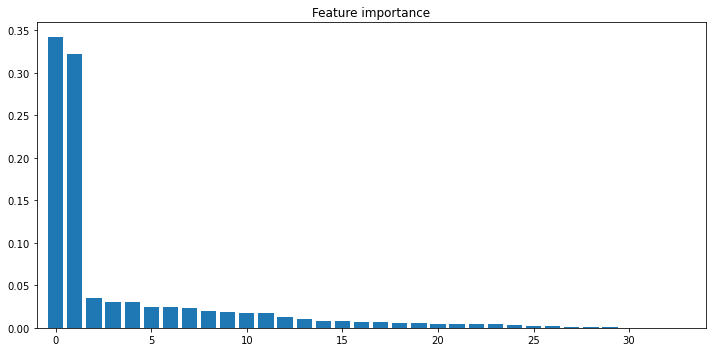

In [27]:
#feat = x_train.columns[1:]
model = xgb.XGBRegressor(max_depth=10, n_estimators=50, learning_rate=0.3, random_state=0)
model.fit(X_train, y_train)
importance = model.feature_importances_
index = np.argsort(importance)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, feats[index[f]],importance[index[f]]))
 
    
plt.figure(figsize=(10,5))    
plt.title('Feature importance')
plt.bar(range(X_train.shape[1]), importance[index], align='center')
#plt.xticks(range(x_train.shape[1]), feats[index], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [28]:
best_feats=[]
for f in range(X_train.shape[1]):
    if importance[index[f]] > 0.007:
        best_feats.append(feats[index[f]])
#best_feats.append('intercept')
best_feats

['area',
 'Класс жилья:_cat',
 'breadcrumbs_5_cat',
 'Количество комнат:_cat',
 'Количество квартир:_cat',
 'Парковка:_cat',
 'Охрана:_cat',
 'Застройщик:_cat',
 'geo_block_1_cat',
 'breadcrumbs_1_cat',
 'geo_block_0_cat',
 'floor',
 'breadcrumbs_3_cat',
 'Площадь кухни:_cat',
 'Количество этажей:_cat',
 'Высота потолков:_cat',
 'breadcrumbs_2_cat']

### Check results

In [29]:
check_log_model(df, best_feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(3.0877903228333987, 0.3557645416840162)

### Optimization of hyperparameters 

In [30]:
xgb_parameters = {
                'n_estimators' : randint(50, 500),
                'max_depth' : randint(2, 10),
                'learning_rate' : uniform(loc = 0, scale = 1),
                'gamma' : uniform(loc = 0, scale = 1),
                'min_child_weight' : randint(1, 5),
                'subsample': uniform(loc = 0, scale = 1),
                'colsample_bytree': uniform(loc = 0, scale = 1),
                'reg_alpha' : uniform(loc = 0, scale = 1),
                'reg_lambda' : uniform(loc = 0, scale = 1),    
                'booster' : ['gbtree', 'gblinear', 'dart'],
                'n_jobs' : [2]
                }

In [31]:
def random_optimization_hp(x, y, hyperparameters, model, n_iter=20, n_jobs = 2, cv = 5):

    rs = RandomizedSearchCV(model, hyperparameters, n_iter = n_iter, n_jobs = n_jobs, cv = cv)
    rs.fit(x, y.values.ravel())
    selected_parameters  = rs.best_params_
    return selected_parameters;


In [32]:
"""
#hiding the code because it takes a very long code execution 
X_train = df_train[best_feats]
y_train = df_train["price"]

selected_parameters_xgb = random_optimization_hp(X_train, y_train, xgb_parameters, xgb.XGBRegressor(), n_iter=20, n_jobs = 2, cv = 5)
"""

'\n#hiding the code because it takes a very long code execution \nX_train = df_train[best_feats]\ny_train = df_train["price"]\n\nselected_parameters_xgb = random_optimization_hp(X_train, y_train, xgb_parameters, xgb.XGBRegressor(), n_iter=20, n_jobs = 2, cv = 5)\n'

In [33]:
#The assignment of a permanent because it takes a very long code execution 
selected_parameters_xgb = {'booster': 'dart',
 'colsample_bytree': 0.7340410495604391,
 'gamma': 0.975366505482443,
 'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 700,
 'n_jobs': 2,
 'reg_alpha': 0.6642504942329533,
 'reg_lambda': 0.08488834287883062,
 'subsample': 0.8268881729914456}

In [34]:
selected_parameters_xgb

{'booster': 'dart',
 'colsample_bytree': 0.7340410495604391,
 'gamma': 0.975366505482443,
 'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 700,
 'n_jobs': 2,
 'reg_alpha': 0.6642504942329533,
 'reg_lambda': 0.08488834287883062,
 'subsample': 0.8268881729914456}

### Check results

In [35]:
check_log_model(df, best_feats, xgb.XGBRegressor(**selected_parameters_xgb))

(3.0877903228333987, 0.3557645416840162)

## Summary of reasult for best features

In [36]:
feats = best_feats

df_train = df[ ~df["price"].isnull() ].copy()
df_test = df[ df["price"].isnull() ].copy()

X_train = df_train[feats]
y_train = df_train["price"]
y_log_train = np.log(y_train)

X_test = df_test[feats]

model = xgb.XGBRegressor(**selected_parameters_xgb)
model.fit(X_train, y_log_train)
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)


## Creat a result file 

In [37]:
#save the data to a file 

df_test["price"] = y_pred
df_test[ ["id", "price"] ].to_csv("../output/xgb_location_log_area.csv", index=False)